<a href="https://colab.research.google.com/github/shinjinigupta/Smart_City_Crime_Watch/blob/main/Fight_Action.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}
%cd /content
!mkdir drive
%cd drive
!mkdir MyDrive
%cd ..
%cd ..
!google-drive-ocamlfuse /content/drive/MyDrive

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 155113 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.27-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.27-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.27-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope

#### Importing the required libaries

In [2]:
# Discard the output of this cell.
%%capture

# Install the required libraries.
!pip install youtube-dl moviepy
!pip install git+https://github.com/TahaAnwar/pafy.git#egg=pafy

In [3]:
# Import the required libraries.
import os
import cv2
import pafy
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt

from moviepy.editor import *
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)3358720/45929032 bytes (7.3%)7217152/45929032 bytes (15.7%)10936320/45929032 bytes (23.8%)14696448/45929032 bytes (32.0%)18456576/45929032 bytes (40.2%)22323200/45929032 bytes (48.6%)26107904/45929032 bytes (56.8%)29818880/45929032 bytes (64.9%)33579008/45929032 bytes (73.1%)37273600/45929032 bytes (81.2%)40951808/45929032 bytes (89.2%)44654592/45929032 bytes (97.2%)

#### Fetching the Dataset

In [4]:
# Create a Matplotlib figure and specify the size of the figure.
plt.figure(figsize = (20, 20))

# Locating the datasets in google drive
fight_data = os.listdir('/content/drive/MyDrive/Colab Notebooks/Final_Proj/Dataset_fight/fight')
nofight_data=os.listdir('/content/drive/MyDrive/Colab Notebooks/Final_Proj/Dataset_fight/noFight')


count_fight=len(fight_data)
print("Count of fight data:",count_fight)

count_nofight=len(nofight_data)
print("Count of no fight data:",count_nofight)

Count of fight data: 150
Count of no fight data: 150


<Figure size 1440x1440 with 0 Axes>

##### Displaying a randomly selected fight data video frame with its label

Fight filename:fi008.mp4


(-0.5, 639.5, 359.5, -0.5)

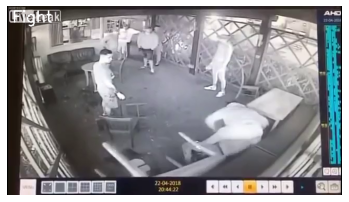

In [5]:
# Randomly selecting a video file from the fight data to display its frame with label
selected_fight_data = random.choice(fight_data)
print("Fight filename:"+ selected_fight_data)

# Initializing a VideoCapture object to read from the video File.
fight_url = '/content/drive/MyDrive/Colab Notebooks/Final_Proj/Dataset_fight/fight'
video_reader = cv2.VideoCapture(f'{fight_url}/{selected_fight_data}')

# Reading the first frame of the video file.
_, bgr_frame = video_reader.read()

# Releasing the VideoCapture object. 
video_reader.release()

# Convert the frame from BGR into RGB format. 
rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

# Write the class name on the video frame.
fight_frame=cv2.putText(rgb_frame, 'Fight', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

# Display the frame.

plt.imshow(fight_frame);plt.axis('off')


##### Displaying a randomly selected non fight data video frame with its label

Fight filename:nofi087.mp4


(-0.5, 319.5, 239.5, -0.5)

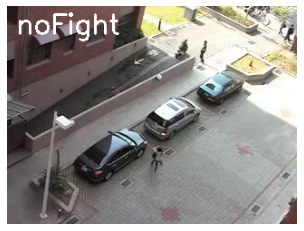

In [6]:
# Randomly selecting a video file from the nofight data to display its frame with label
selected_nofight_data = random.choice(nofight_data)
print("Fight filename:"+ selected_nofight_data)

# Initializing a VideoCapture object to read from the video File.
nofight_url = '/content/drive/MyDrive/Colab Notebooks/Final_Proj/Dataset_fight/noFight'
video_reader = cv2.VideoCapture(f'{nofight_url}/{selected_nofight_data}')

# Reading the first frame of the video file.
_, bgr_frame = video_reader.read()

# Releasing the VideoCapture object. 
video_reader.release()

# Convert the frame from BGR into RGB format. 
rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

# Write the class name on the video frame.
nofight_frame=cv2.putText(rgb_frame, 'noFight', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

# Display the frame.

plt.imshow(nofight_frame);plt.axis('off')

#### Preprocessing the data

In [7]:
# Specifying the height and width to which each video frame will be resized in our dataset.
IMAGE_HEIGHT , IMAGE_WIDTH = 224, 224

# Specifying the number of frames of a video that will be fed to the model as one sequence.
SEQUENCE_LENGTH = 10

# Specifying the directory containing the fight action dataset. 
DATASET_DIR = "/content/drive/MyDrive/Colab Notebooks/Final_Proj/Dataset_fight"

# Specifying the list containing the names of the classes used for training. Feel free to choose any set of classes.
CLASSES_LIST = ["fight", "nofight"]

##### Creating a function to extract, resize and normalize the video frames

In [8]:
def frames_extraction(video_path):
    '''
    This function will extract the required frames from a video after resizing and normalizing them.
    Args:
        video_path: The path of the video in the disk, whose frames are to be extracted.
    Returns:
        frames_list: A list containing the resized and normalized frames of the video.
    '''

    # Declare a list to store video frames.
    frames_list = []
    
    # Read the Video File using the VideoCapture object.
    video_reader = cv2.VideoCapture(video_path)

    # Get the total number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

    # Iterate through the Video Frames.
    for frame_counter in range(SEQUENCE_LENGTH):

        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        # Reading the frame from the video. 
        success, frame = video_reader.read() 

        # Check if Video frame is not successfully read then break the loop
        if not success:
            break

        # Resize the Frame to fixed height and width.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        
        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255
        
        # Append the normalized frame into the frames list
        frames_list.append(normalized_frame)
    
    # Release the VideoCapture object. 
    video_reader.release()

    # Return the frames list.
    return frames_list

##### Creating a function for dataset creation by extracting frames from the videos

In [9]:
def create_dataset():
    '''
    This function will extract the data of the selected classes and create the required dataset.
    Returns:
        features:          A list containing the extracted frames of the videos.
        labels:            A list containing the indexes of the classes associated with the videos.
        video_files_paths: A list containing the paths of the videos in the disk.
    '''

    # Declared Empty Lists to store the features, labels and video file path values.
    features = []
    labels = []
    video_files_paths = []
    
    # Iterating through all the classes mentioned in the classes list
    for class_index, class_name in enumerate(CLASSES_LIST):
        
        # Display the name of the class whose data is being extracted.
        print(f'Extracting Data of Class: {class_name}')
        
        # Get the list of video files present in the specific class name directory.
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))
        
        # Iterate through all the files present in the files list.
        for file_name in files_list:
            
            # Get the complete video path.
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)

            # Extract the frames of the video file.
            frames = frames_extraction(video_file_path)

            # Check if the extracted frames are equal to the SEQUENCE_LENGTH specified above.
            # So ignore the vides having frames less than the SEQUENCE_LENGTH.
            if len(frames) == SEQUENCE_LENGTH:

                # Append the data to their repective lists.
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)

    # Converting the list to numpy arrays
    features = np.asarray(features)
    labels = np.array(labels)  
    
    # Return the frames, class index, and video file path.
    return features, labels, video_files_paths

##### Calling the function to create the dataset to train our model.

In [ ]:
# Create the dataset.
features, labels, video_files_paths = create_dataset()

Extracting Data of Class: fight
Extracting Data of Class: nofight


In [ ]:
# creating pickle file to save the extracted features
import pickle
import os

pickle.dump(features,open("/content/drive/MyDrive/Colab Notebooks/Final_Proj/fight_features.dat","wb"), protocol=4)
pickle.dump(labels,open("/content/drive/MyDrive/Colab Notebooks/Final_Proj/fight_labels.dat","wb"), protocol=4)
pickle.dump(video_files_paths,open("/content/drive/MyDrive/Colab Notebooks/Final_Proj/fight_video_files_paths.dat","wb"), protocol=4)

In [10]:
# loading the features from the saved pickle file
import pickle
import os

features=pickle.load(open("/content/drive/MyDrive/Colab Notebooks/Final_Proj/fight_features.dat","rb"))
labels=pickle.load(open("/content/drive/MyDrive/Colab Notebooks/Final_Proj/fight_labels.dat","rb"))
video_files_paths=pickle.load(open("/content/drive/MyDrive/Colab Notebooks/Final_Proj/fight_video_files_paths.dat","rb"))

##### Converting labels (class indexes) into one-hot encoded vectors.

In [11]:
# Using Keras's to_categorical method to convert labels into one-hot-encoded vectors

from tensorflow.keras.utils import to_categorical
one_hot_encoded_labels = to_categorical(labels)

#### Creating the train and test datasets

In [12]:
# Split the Data into Train ( 75% ) and Test Set ( 25% ).

from sklearn.model_selection import train_test_split
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels,
                                                                            test_size = 0.30, shuffle = True,
                                                                            )

In [13]:
labels_test

array([[1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.

#### Creating the LRCN model with pretrained inception V3 & LSTM

In [14]:
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

from tensorflow.keras import optimizers
from tensorflow import keras
import tensorflow as tf
 
from keras.applications.resnet_v2 import ResNet50V2
from keras.layers import Dense, LSTM,  Flatten, TimeDistributed, Conv2D, Dropout
from keras import Sequential
from keras.models import Model


In [ ]:
inceptionv3_model=keras.applications.InceptionV3(
        weights="imagenet",
        include_top=False,
        #pooling="avg",
        input_shape=(IMAGE_HEIGHT , IMAGE_WIDTH, 3),
    )


for layer in inceptionv3_model.layers[:249]:
    layer.trainable = False
for layer in inceptionv3_model.layers[249:]:
    layer.trainable = True

for layer in inceptionv3_model.layers:
  #sp='  '[len(layer.name)]
  print(layer.name,layer.trainable)

87924736/87910968 [==============================] - 0s 0us/step
input_1 False
conv2d False
batch_normalization False
activation False
conv2d_1 False
batch_normalization_1 False
activation_1 False
conv2d_2 False
batch_normalization_2 False
activation_2 False
max_pooling2d False
conv2d_3 False
batch_normalization_3 False
activation_3 False
conv2d_4 False
batch_normalization_4 False
activation_4 False
max_pooling2d_1 False
conv2d_8 False
batch_normalization_8 False
activation_8 False
conv2d_6 False
conv2d_9 False
batch_normalization_6 False
batch_normalization_9 False
activation_6 False
activation_9 False
average_pooling2d False
conv2d_5 False
conv2d_7 False
conv2d_10 False
conv2d_11 False
batch_normalization_5 False
batch_normalization_7 False
batch_normalization_10 False
batch_normalization_11 False
activation_5 False
activation_7 False
activation_10 False
activation_11 False
mixed0 False
conv2d_15 False
batch_normalization_15 False
activation_15 False
conv2d_13 False
conv2d_16 False
b

In [ ]:
def create_LRCN_model():
    '''
    This function will construct the required LRCN model.
    Returns:
        model: It is the required constructed LRCN model.
    '''
    '''inceptionv3_model=keras.applications.InceptionV3(
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=(IMAGE_HEIGHT , IMAGE_WIDTH, 3),
    )'''
    # We will use a Sequential model for model construction.
    model = Sequential()
    
    # Define the Model Architecture.
    
    model.add(TimeDistributed(inceptionv3_model,
                              input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
                                      
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(256, activation='relu', return_sequences=False))
    
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(.2))
    model.add(Dense(len(CLASSES_LIST), activation = 'sigmoid'))


    # Display the models summary.
    model.summary()
    
    # Return the constructed LRCN model.
    return model

In [ ]:
def create_LRCN_model_CNN():
    '''
    This function will construct the required LRCN model.
    Returns:
        model: It is the required constructed LRCN model.
    '''

    # We will use a Sequential model for model construction.
    model = Sequential()
    
    # Define the Model Architecture.
    ########################################################################################################################
    
    model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same',activation = 'relu'),
                              input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    
    model.add(TimeDistributed(MaxPooling2D((4, 4)))) 
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    #model.add(TimeDistributed(Dropout(0.25)))
                                      
    model.add(TimeDistributed(Flatten()))
                                      
    model.add(LSTM(32))
                                      
    model.add(Dense(len(CLASSES_LIST), activation = 'softmax'))

    ########################################################################################################################

    # Display the models summary.
    model.summary()
    
    # Return the constructed LRCN model.
    return model

In [20]:
ResNet50V2 = ResNet50V2(
    include_top=False,
    weights='imagenet',
    #input_shape=(224, 224, 3)
    input_shape=(IMAGE_HEIGHT , IMAGE_WIDTH, 3)
)
# do not train first layers, I want to only train
# the 4 last layers 
for layer in ResNet50V2.layers:
    layer.trainable = True# create a Sequential model
model = Sequential()# add vgg model for 10 input images (keeping the right shape
model.add( TimeDistributed(ResNet50V2, input_shape=(10, 224, 224, 3)))# now, flatten on each output to send 5 
# outputs with one dimension to LSTM
model.add(
    TimeDistributed(
        Flatten()
    )
)
model.add(LSTM(256, activation='relu', return_sequences=False))# finalize with standard Dense, Dropout...
model.add(Dense(64, activation='relu'))
model.add(Dropout(.2))
model.add(Dense(2, activation='sigmoid'))
model.compile('adam', loss='binary_crossentropy', metrics=["accuracy"])

convlstm_model_training_history=model.fit(features_train, labels_train, batch_size=20, epochs=20, validation_data=(features_test, labels_test), verbose=1)

ValueError: ignored

#### Creating our LRCN model

In [ ]:
# Construct the required LRCN model.
LRCN_model = create_LRCN_model()

# Display the success message.
print("Model Created Successfully!")

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_4 (TimeDis  (None, 10, 5, 5, 2048)   21802784  
 tributed)                                                       
                                                                 
 time_distributed_5 (TimeDis  (None, 10, 51200)        0         
 tributed)                                                       
                                                                 
 lstm_2 (LSTM)               (None, 256)               52691968  
                                                                 
 dense_4 (Dense)             (None, 64)                16448     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 2)                

#### Checking model structure

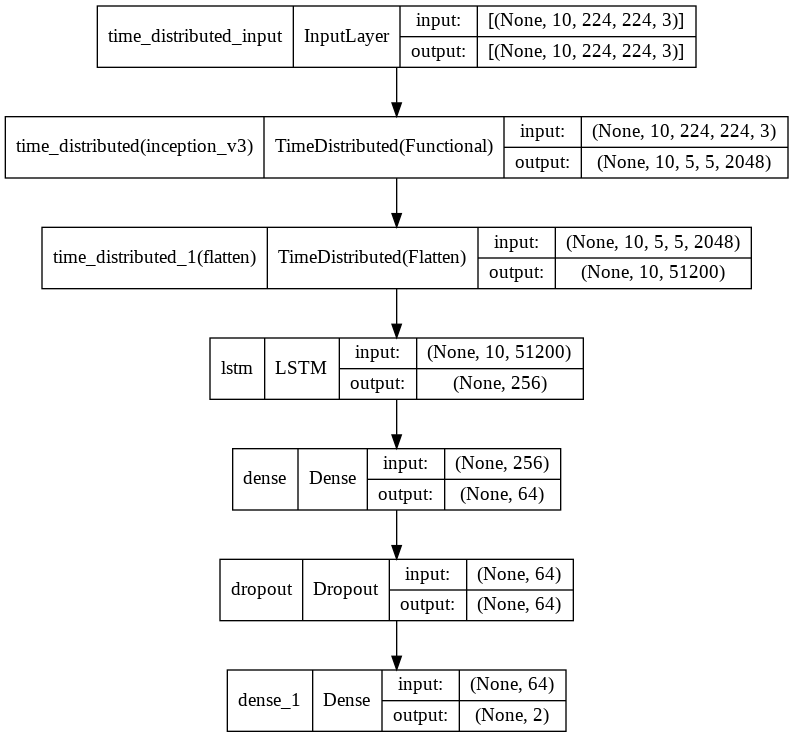

In [ ]:
# Plot the structure of the contructed LRCN model.
plot_model(LRCN_model, to_file = 'LRCN_model_structure_plot.png', show_shapes = True, show_layer_names = True)

#### Compiling &training the model

In [ ]:
# Create an Instance of Early Stopping Callback.
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)
 
# Compile the model and specify loss function, optimizer and metrics to the model.
LRCN_model.compile(loss = 'binary_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

# Start training the model.
#LRCN_model_training_history = LRCN_model.fit(x = features_train, y = labels_train, epochs = 70, batch_size = 4 , shuffle = True, validation_split = 0.2) #callbacks = [early_stopping_callback])
LRCN_model_training_history = LRCN_model.fit(x = features_train, y = labels_train, epochs = 70, batch_size = 4 , validation_data = (features_test, labels_test))

Epoch 1/70
53/53 [==============================] - 18s 233ms/step - loss: 21.2710 - accuracy: 0.5429 - val_loss: 41.7738 - val_accuracy: 0.6222
Epoch 2/70
53/53 [==============================] - 10s 182ms/step - loss: 8.4794 - accuracy: 0.6000 - val_loss: 15.2886 - val_accuracy: 0.6333
Epoch 3/70
53/53 [==============================] - 10s 185ms/step - loss: 6.5771 - accuracy: 0.6571 - val_loss: 23.7898 - val_accuracy: 0.5556
Epoch 4/70
53/53 [==============================] - 10s 181ms/step - loss: 6.1419 - accuracy: 0.6429 - val_loss: 5.6312 - val_accuracy: 0.6444
Epoch 5/70
53/53 [==============================] - 10s 182ms/step - loss: 3.9105 - accuracy: 0.6524 - val_loss: 4.1778 - val_accuracy: 0.5667
Epoch 6/70
53/53 [==============================] - 10s 182ms/step - loss: 1.5738 - accuracy: 0.7476 - val_loss: 2.2359 - val_accuracy: 0.7222
Epoch 7/70
53/53 [==============================] - 10s 181ms/step - loss: 1.4862 - accuracy: 0.8143 - val_loss: 2.4819 - val_accuracy: 0.

In [16]:
#Testing the accuracy on test data

#test_prediction = LRCN_model.evaluate(features_test, labels_test, verbose=1)
test_prediction = model.evaluate(features_test, labels_test, verbose=1)

print("Accuracy: %.2f%%" % (test_prediction[1]*100))
print("Loss: %.2f%%" %((test_prediction[0]*100)))

3/3 [==============================] - 4s 1s/step - loss: 11.8031 - accuracy: 0.6222
Accuracy: 62.22%
Loss: 1180.31%
